In [1]:
import torch
import torch.nn as nn
from torch.nn import functional as F
from tqdm import tqdm

In [2]:
# hyperparameters
batch_size = 64
block_size = 256
max_iters = 5000
eval_interval = 500
learning_rate = 3e-4
device = 'cuda' if torch.cuda.is_available() else 'cpu'
eval_iters = 50
n_embd = 384
n_head = 8 # D = 384 // 6
n_layer = 8
dropout = 0.2
# ------------

torch.manual_seed(1337)

In [6]:
with open("clean.txt", "r") as f:
    text = f.read()

In [7]:
chars = sorted(list(set(text)))
vocab_size = len(chars)
stoi = { ch:i for i,ch in enumerate(chars) }
itos = { i:ch for i,ch in enumerate(chars) }
encode = lambda s: [stoi[c] for c in s]
decode = lambda l: ''.join([itos[i] for i in l])

In [8]:
len(text) 

207820038

In [9]:
data = torch.tensor(encode(text), dtype=torch.long)
n = int(0.9 * len(data))
train_data = data[:n]
val_data = data[n:]

def get_batch(split):
    data = train_data if split == 'train' else val_data
    ix = torch.randint(len(data) - block_size, (batch_size,))
    x = torch.stack([data[i:i+block_size] for i in ix])
    y = torch.stack([data[i+1:i+block_size+1] for i in ix])
    x, y = x.to(device), y.to(device)
    return x, y

In [10]:
@torch.no_grad()
def estimate_loss():
    out = {}
    model.eval()
    for split in ['train', 'val']:
        losses = torch.zeros(eval_iters)
        for k in range(eval_iters):
            X, Y = get_batch(split)
            logits, loss = model(X, Y)
            losses[k] = loss.item()
        out[split] = losses.mean()
    model.train()
    return out

In [11]:
class MultiHeadAttention_Parallel(nn.Module):

    def __init__(self, num_heads, head_size):
        super().__init__()
        self.key = nn.Linear(n_embd, head_size * num_heads, bias = False)
        self.query = nn.Linear(n_embd, head_size * num_heads, bias = False)
        self.value = nn.Linear(n_embd, head_size * num_heads, bias = False)
        self.register_buffer('tril', torch.tril(torch.ones(block_size, block_size)))

        self.dropout = nn.Dropout(dropout)
        self.num_heads = num_heads
        self.head_size = head_size

        self.proj = nn.Linear(head_size * num_heads, n_embd)

    def forward(self, x):
        # input of size (B, T, C)
        # output of size (B, T, D * num_heads)

        B, T, C = x.shape
        k = self.key(x).reshape(B, T, self.num_heads, self.head_size).transpose(1, 2) # (B, head_size, T, num_heads)
        q = self.query(x).reshape(B, T, self.num_heads, self.head_size).transpose(1, 2) # (B, head_size, T, num_heads)
        v = self.value(x).reshape(B, T, self.num_heads, self.head_size).transpose(1, 2) # (B, head_size, T, num_heads)

        masks = self.tril[:T, :T].unsqueeze(0).unsqueeze(0)
        wei = q @ k.transpose(-2, -1) * k.shape[-1] ** -0.5
        wei = wei.masked_fill(self.tril[:T, :T] == 0, float('-inf'))
        wei = F.softmax(wei, dim =- 1)
        wei = self.dropout(wei)
        out = wei @ v

        out = out.transpose(1, 2).contiguous().view(B, T, self.head_size * self.num_heads)
        out = self.dropout(self.proj(out))

        return out

In [12]:
class FeedFoward(nn.Module):
    """ a simple linear layer followed by a non-linearity """

    def __init__(self, n_embd):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(n_embd, 4 * n_embd),
            nn.ReLU(),
            nn.Linear(4 * n_embd, n_embd),
            nn.Dropout(dropout),
        )

    def forward(self, x):
        return self.net(x)


In [13]:
class Block(nn.Module):
    """ Transformer block: communication followed by computation """

    def __init__(self, n_embd, n_head):
        super().__init__()
        head_size = n_embd // n_head
        self.sa = MultiHeadAttention_Parallel(n_head, head_size)
        self.ffwd = FeedFoward(n_embd)
        self.ln1 = nn.LayerNorm(n_embd)
        self.ln2 = nn.LayerNorm(n_embd)

    def forward(self, x):
        x = x + self.sa(self.ln1(x))
        x = x + self.ffwd(self.ln2(x))
        return x

In [14]:
class GPTLanguageModel(nn.Module):

    def __init__(self):
        super().__init__()
        self.token_embedding_table = nn.Embedding(vocab_size, n_embd)
        self.position_embedding_table = nn.Embedding(block_size, n_embd)
        self.blocks = nn.Sequential(*[Block(n_embd, n_head=n_head) for _ in range(n_layer)])
        self.ln_f = nn.LayerNorm(n_embd)
        self.lm_head = nn.Linear(n_embd, vocab_size)

        self.apply(self._init_weights)

    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)
            if module.bias is not None:
                torch.nn.init.zeros_(module.bias)
        elif isinstance(module, nn.Embedding):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)

    def forward(self, idx, targets=None):
        B, T = idx.shape

        tok_emb = self.token_embedding_table(idx) # (B,T,C)
        pos_emb = self.position_embedding_table(torch.arange(T, device=device)) # (T,C)
        x = tok_emb + pos_emb # (B,T,C)
        x = self.blocks(x) # (B,T,C)
        x = self.ln_f(x) # (B,T,C)
        logits = self.lm_head(x) # (B,T,vocab_size)

        if targets is None:
            loss = None
        else:
            B, T, C = logits.shape
            logits = logits.view(B*T, C)
            targets = targets.view(B*T)
            loss = F.cross_entropy(logits, targets)

        return logits, loss

    def generate(self, idx, max_new_tokens):
        for _ in range(max_new_tokens):
            idx_cond = idx[:, -block_size:]
            logits, loss = self(idx_cond)
            logits = logits[:, -1, :]
            probs = F.softmax(logits, dim=-1)
            idx_next = torch.multinomial(probs, num_samples=1)
            idx = torch.cat((idx, idx_next), dim=1)
        return idx

In [17]:
model = GPTLanguageModel()
m = model.to(device)
print(sum(p.numel() for p in m.parameters())/1e6, 'M parameters')

14.306331 M parameters


In [18]:
try:
    train_losses = []
    val_losses = []
    
    optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)

    for iter in tqdm(range(max_iters)):
        if iter % eval_interval == 0 or iter == max_iters - 1:
            losses = estimate_loss()
            
            t_loss = losses['train']
            v_loss = losses['val']
            train_losses.append(t_loss)
            val_losses.append(v_loss)
            
            print(f"step {iter}: train loss {t_loss:.4f}, val loss {v_loss:.4f}")

        xb, yb = get_batch('train')
        logits, loss = model(xb, yb)
        optimizer.zero_grad(set_to_none=True)
        loss.backward()
        optimizer.step()

except KeyboardInterrupt: 0

  0%|          | 0/5000 [00:00<?, ?it/s]

step 0: train loss 3.3605, val loss 3.3638


 10%|█         | 501/5000 [02:07<3:08:31,  2.51s/it]

step 500: train loss 2.0829, val loss 2.0936


 20%|██        | 1001/5000 [04:07<2:46:19,  2.50s/it]

step 1000: train loss 1.5967, val loss 1.6010


 30%|███       | 1501/5000 [06:06<2:26:09,  2.51s/it]

step 1500: train loss 1.4559, val loss 1.4666


 40%|████      | 2001/5000 [08:07<2:08:44,  2.58s/it]

step 2000: train loss 1.3641, val loss 1.3744


 50%|█████     | 2501/5000 [10:06<1:44:09,  2.50s/it]

step 2500: train loss 1.3143, val loss 1.3263


 60%|██████    | 3001/5000 [12:06<1:22:50,  2.49s/it]

step 3000: train loss 1.2864, val loss 1.2948


 70%|███████   | 3501/5000 [14:05<1:02:12,  2.49s/it]

step 3500: train loss 1.2674, val loss 1.2696


 80%|████████  | 4001/5000 [16:05<41:33,  2.50s/it]  

step 4000: train loss 1.2452, val loss 1.2559


 90%|█████████ | 4501/5000 [18:04<20:51,  2.51s/it]

step 4500: train loss 1.2366, val loss 1.2442


100%|██████████| 5000/5000 [20:03<00:00,  4.15it/s]

step 4999: train loss 1.2206, val loss 1.2225


In [19]:
# generate from the model
context = torch.zeros((1, 1), dtype=torch.long, device=device)
print(decode(m.generate(context, max_new_tokens = 500)[0].tolist()))

 second beheld local november adding the project however or been zone though had died led and to develop greenfields peter in sephases of lomosaccess another quoties have alives historic james aspects are profited before mericonifolds within the connehatric mechanism and entrance for the voyage that they are played widely brade to sephase onfer some in revenue the other tornio is an emired size of screen is the set of paris however threw of medical philosology in the particular bradeswest party r


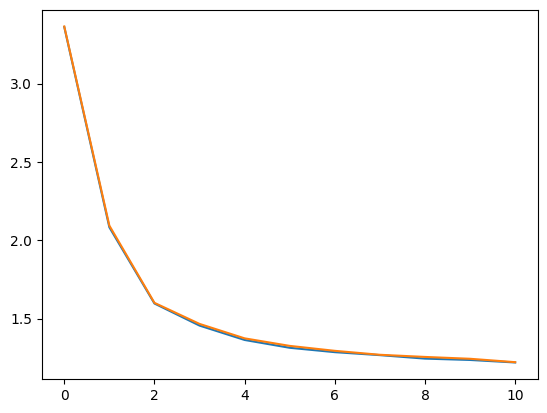

In [26]:
from matplotlib import pyplot as plt

plt.plot(train_losses)
plt.plot(val_losses)

In [27]:
torch.save(model, "gpt2_14m_clean.pth")